# RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда
нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое,
чтобы можно было обучить хорошую стратегию методами TD-обучения или другими
методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том
числе и достаточно техническое, так что для решения придётся немножко
попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук
на вашем github (или публичный, или с доступом для snikolenko); ссылку
обязательно нужно прислать в виде сданного домашнего задания на портале
Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда,
категорически приветствуются.

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая
реализована в OpenAI Gym:

* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для
валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит
21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко,
если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
    * hit — взять ещё одну карту;
    * stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока
сумма карт в его руке меньше 17;
*  после этого игрок выигрывает, если дилер либо превышает 21, либо получает
сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется
ничья (ставка возвращается);
*  в исходных правилах есть ещё дополнительный бонус за natural blackjack: если
игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5
(полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

In [5]:
import gym
from collections import defaultdict
import tqdm
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [7]:
env = gym.make('Blackjack-v0', natural=True)

In [8]:
observation = env.reset()
print(f'observation: {observation}')
done = False
while not done:
    if observation[0] < 19:
        observation, reward, done, _ = env.step(1)
        print(f"observation: {observation}, reward: {reward}, done: {done}")
    else:
        observation, reward, done, _ = env.step(0)
        print(f"observation: {observation}, reward: {reward}, done: {done}")
    

observation: (14, 4, False)
observation: (19, 4, False), reward: 0.0, done: False
observation: (19, 4, False), reward: 1.0, done: True


In [79]:
def run_episode(env, pi, eps=.01):
    observation = env.reset()
    # states, rewards, actions = [], [], []
    done = False
    
    while not done:
        # epsilon policy
        action = pi[observation] if np.random.rand() > eps else env.action_space.sample()
        # states.append(observation)
        # actions.append(action)
        observation, reward, done, _ = env.step(action)
        # rewards.append(reward)

    return reward

### 1.1 Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [80]:
# в дискретном пространстве состояний можно записать стратегию 
# как словарь состоягие -> действие

states_list = list(
    itertools.product(
        range(2, 33), # the players current sum, 32 для Q learning !!!!!!!!
        range(1, 11), # the dealer's one showing card (1-10 where 1 is ace),
        (True, False) # the player holds a usable ace
    )
)

In [81]:
# если сумма меньше 19, то hit
pi = {
    state: int(state[0] < 19)
    for state in states_list
}

In [99]:
def avg_reward(env, pi, epochs=100000):
    sum_reward = 0
    cnt = 0
    for _ in tqdm.tqdm(range(epochs)):
        cnt += 1
        reward = run_episode(env, pi, eps=0.)
        sum_reward += reward
    return sum_reward / cnt

In [83]:
avg_reward(env, pi)

-0.18391

### 1.2 Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [84]:
def get_random_Q(env):
    # инициализируем случайным образом
    Q = {
        state: np.zeros(env.action_space.n) #np.random.random(env.action_space.n)
        for state in states_list
    }
    for state in states_list:
        if state[0] == 21:
            Q[state] = np.zeros(env.action_space.n)   
    return Q

def compute_policy_by_Q(env, Q, gamma=1.0):
    return {key: np.argmax(value) for key, value in Q.items()}

In [ ]:
def run_Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.05, gamma=0.9, max_steps=1000000):
    env.reset()
    s = env.get_obs_id(env._get_obs())
    a = pi[s] if random.random() > epsilon else env.action_space.sample()
    for _ in range(1000):    
        obs, reward, done, info = env.step(a)
        s_prime = env.get_obs_id(obs)
        a_prime = pi[s_prime] if random.random() > epsilon else env.action_space.sample()
        Q[s][a] += alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            return Q, reward
    return None, None

In [91]:
def Q_learning_episode(env, pi, Q, alpha=0.1, epsilon=0.1, gamma=0.9):
    done = False
    observation = env.reset()
    while not done:
        a = pi[observation] if np.random.rand() > epsilon else env.action_space.sample()
        observation_prime, reward, done, _ = env.step(a)
        # print(observation_prime, reward, done)
        Q[observation][a] += alpha * (
            reward + gamma * np.max(Q[observation_prime]) - Q[observation][a]
        )
        observation = observation_prime
    return Q

In [88]:
Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)
Q_learning_episode(env, pi, Q, epsilon=1)

(13, 10, False) 0.0 False
(15, 10, False) 0.0 False
(19, 10, False) 0.0 False
(19, 10, False) -1.0 True


{(2, 1, True): array([0., 0.]),
 (2, 1, False): array([0., 0.]),
 (2, 2, True): array([0., 0.]),
 (2, 2, False): array([0., 0.]),
 (2, 3, True): array([0., 0.]),
 (2, 3, False): array([0., 0.]),
 (2, 4, True): array([0., 0.]),
 (2, 4, False): array([0., 0.]),
 (2, 5, True): array([0., 0.]),
 (2, 5, False): array([0., 0.]),
 (2, 6, True): array([0., 0.]),
 (2, 6, False): array([0., 0.]),
 (2, 7, True): array([0., 0.]),
 (2, 7, False): array([0., 0.]),
 (2, 8, True): array([0., 0.]),
 (2, 8, False): array([0., 0.]),
 (2, 9, True): array([0., 0.]),
 (2, 9, False): array([0., 0.]),
 (2, 10, True): array([0., 0.]),
 (2, 10, False): array([0., 0.]),
 (3, 1, True): array([0., 0.]),
 (3, 1, False): array([0., 0.]),
 (3, 2, True): array([0., 0.]),
 (3, 2, False): array([0., 0.]),
 (3, 3, True): array([0., 0.]),
 (3, 3, False): array([0., 0.]),
 (3, 4, True): array([0., 0.]),
 (3, 4, False): array([0., 0.]),
 (3, 5, True): array([0., 0.]),
 (3, 5, False): array([0., 0.]),
 (3, 6, True): array([0

In [109]:
env.close()
env = gym.make('Blackjack-v0', natural=True)

def Q_learning(env, alpha=0.005, epsilon=0.05, gamma=0.1, epochs=500000, track_history=False):
    # Q_hist_Qlearn = [ ]
    pi_hist = []

    Q = get_random_Q(env)
    pi = compute_policy_by_Q(env, Q)

    for n in tqdm.tqdm(range(epochs)):
        Q = Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        pi = compute_policy_by_Q(env, Q)
        # Q_hist_Qlearn.append(copy.deepcopy(Q))
        if n % 25000 == 0 and track_history:
            pi_hist.append(pi)
            
    return pi, pi_hist

In [110]:
pi, pi_hist = Q_learning(env, track_history=True)

100%|██████████| 500000/500000 [07:43<00:00, 1078.12it/s]


In [111]:
avg_reward(env, pi)

100%|██████████| 100000/100000 [00:06<00:00, 14429.28it/s]


-0.026125

### 1.3 Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [105]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

100%|██████████| 200000/200000 [00:13<00:00, 14589.85it/s]


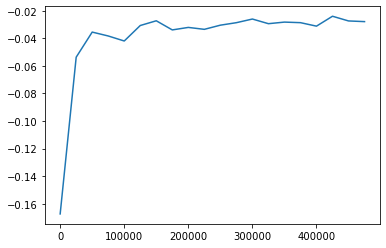

In [108]:
plt.plot(list(range(0, 500000, 25000)), avg_reward_hist)

### 1.3 Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [121]:
def tuning_params(
    env,
    alpha_values,
    epsilon_values,
    gamma_values,
    train_epochs=500000,
    eval_epochs=200000
):
    best_reward, best_pi, best_alpha, best_epsilon, best_gamma = -np.inf, None, None, None, None
    for i, (alpha, epsilon, gamma) in enumerate(
        itertools.product(alpha_values, epsilon_values, gamma_values)
    ):
        pi, _ = Q_learning(
            env=env,
            alpha=alpha,
            epsilon=epsilon,
            gamma=gamma,
            epochs=train_epochs,
        )
        reward = avg_reward(env, pi, epochs=eval_epochs)
        print(reward)
        if reward > best_reward:
            best_reward = reward
            best_pi = pi
            best_alpha = alpha
            best_epsilon = epsilon
            best_gamma = gamma
            
        print(f'Best reward: {best_reward:.4f}.')
        print(f'alpha = {best_alpha:.4f}, epsilon = {best_epsilon:.4f}, gamma = {best_gamma:.2f}.')

    return best_alpha, best_epsilon, best_gamma

In [122]:
env.close()
env = gym.make('Blackjack-v0', natural=True)

best_alpha, best_epsilon, best_gamma = tuning_params(
    env=env,
    alpha_values=np.arange(0.002, 0.010, 0.001),
    epsilon_values=np.arange(0.05, 0.15, 0.05),
    gamma_values=np.arange(0.05, 0.15, 0.05),
    train_epochs=100000,
    eval_epochs=100000
)

  0%|          | 103/100000 [00:00<01:37, 1025.39it/s]

-0.04695
Best reward: -0.0469.
alpha = 0.0020, epsilon = 0.0500, gamma = 0.05.


  0%|          | 117/100000 [00:00<01:25, 1163.64it/s]

-0.04036
Best reward: -0.0404.
alpha = 0.0020, epsilon = 0.0500, gamma = 0.10.


  0%|          | 102/100000 [00:00<01:39, 1007.66it/s]

-0.037615
Best reward: -0.0376.
alpha = 0.0020, epsilon = 0.1000, gamma = 0.05.


  0%|          | 99/100000 [00:00<01:41, 987.93it/s]

-0.03359
Best reward: -0.0336.
alpha = 0.0020, epsilon = 0.1000, gamma = 0.10.


  0%|          | 103/100000 [00:00<01:37, 1026.68it/s]

-0.03821
Best reward: -0.0336.
alpha = 0.0020, epsilon = 0.1000, gamma = 0.10.


  0%|          | 104/100000 [00:00<01:36, 1035.16it/s]

-0.034985
Best reward: -0.0336.
alpha = 0.0020, epsilon = 0.1000, gamma = 0.10.


  0%|          | 107/100000 [00:00<01:33, 1067.68it/s]

-0.038505
Best reward: -0.0336.
alpha = 0.0020, epsilon = 0.1000, gamma = 0.10.


  0%|          | 104/100000 [00:00<01:36, 1035.20it/s]

-0.028355
Best reward: -0.0284.
alpha = 0.0030, epsilon = 0.1000, gamma = 0.10.


  0%|          | 99/100000 [00:00<01:41, 982.29it/s]

-0.045945
Best reward: -0.0284.
alpha = 0.0030, epsilon = 0.1000, gamma = 0.10.


  0%|          | 116/100000 [00:00<01:26, 1153.81it/s]

-0.036985
Best reward: -0.0284.
alpha = 0.0030, epsilon = 0.1000, gamma = 0.10.


  0%|          | 107/100000 [00:00<01:33, 1064.17it/s]

-0.029135
Best reward: -0.0284.
alpha = 0.0030, epsilon = 0.1000, gamma = 0.10.


  0%|          | 117/100000 [00:00<01:25, 1163.95it/s]

-0.03607
Best reward: -0.0284.
alpha = 0.0030, epsilon = 0.1000, gamma = 0.10.


  0%|          | 116/100000 [00:00<01:26, 1155.89it/s]

-0.031955
Best reward: -0.0284.
alpha = 0.0030, epsilon = 0.1000, gamma = 0.10.


  0%|          | 105/100000 [00:00<01:35, 1042.26it/s]

-0.027525
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 101/100000 [00:00<01:38, 1009.58it/s]

-0.036795
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 107/100000 [00:00<01:33, 1064.95it/s]

-0.038425
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 109/100000 [00:00<01:32, 1085.10it/s]

-0.03265
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 115/100000 [00:00<01:26, 1149.95it/s]

-0.030205
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 113/100000 [00:00<01:28, 1129.87it/s]

-0.03426
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 116/100000 [00:00<01:26, 1151.96it/s]

-0.03496
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 116/100000 [00:00<01:26, 1154.71it/s]

-0.03469
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 116/100000 [00:00<01:26, 1157.58it/s]

-0.031275
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 115/100000 [00:00<01:27, 1144.42it/s]

-0.035995
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 114/100000 [00:00<01:27, 1138.30it/s]

-0.034215
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


  0%|          | 115/100000 [00:00<01:27, 1143.68it/s]

-0.040145
Best reward: -0.0275.
alpha = 0.0050, epsilon = 0.0500, gamma = 0.10.


 97%|█████████▋| 96654/100000 [01:30<00:03, 1067.22it/s]


KeyboardInterrupt: 

In [126]:
best_alpha = 0.0050
best_epsilon = 0.0500
best_gamma = 0.10

In [127]:
pi, pi_hist = Q_learning(
    env, 
    alpha=best_alpha,
    epsilon=best_epsilon, 
    gamma=best_gamma, 
    epochs=250001,
    track_history=True
)

100%|██████████| 250001/250001 [03:46<00:00, 1101.66it/s]


100%|██████████| 200000/200000 [00:13<00:00, 14832.73it/s]


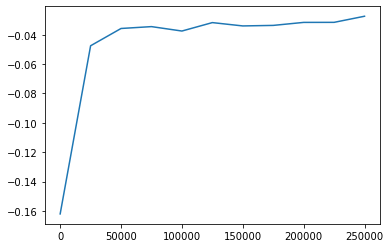

In [128]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

plt.plot(list(range(0, 250001, 25000)), avg_reward_hist)

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли
получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила
были упрощёнными, а на самом деле у игрока есть ещё и другие возможности.
Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением
ставки. Итак, у игрока появляется дополнительное действие:
* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 2.1 Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [130]:
from gym.envs.toy_text import BlackjackEnv

In [211]:
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


class DoubleBlackjackEnv(BlackjackEnv):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def draw_card(self, np_random):
        return int(np_random.choice(deck))

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double: add a card to players hand and finish game, reward will be doubled
            _, reward, done, _ = self.step(action=1) # hit
            if not done:
                _, reward, done, _ = self.step(action=0) # stick
            reward *= 2

        elif action == 1: # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0

        else:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(self.score(self.player), self.score(self.dealer))
            if self.sab and self.is_natural(self.player) and not self.is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and self.is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

### 2.2 Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [215]:
env = DoubleBlackjackEnv(natural=True)

In [216]:
best_alpha = 0.0050
best_epsilon = 0.0500
best_gamma = 0.10

In [217]:
pi, pi_hist = Q_learning(
    env, 
    alpha=best_alpha,
    epsilon=best_epsilon, 
    gamma=best_gamma, 
    epochs=250001,
    track_history=True
)

100%|██████████| 250001/250001 [03:55<00:00, 1060.36it/s]


100%|██████████| 200000/200000 [00:14<00:00, 13846.32it/s]


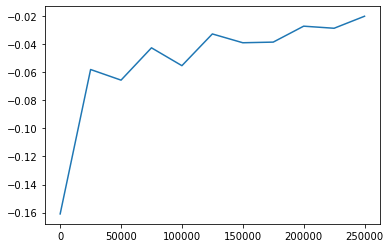

In [218]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

plt.plot(list(range(0, 250001, 25000)), avg_reward_hist)

## Часть третья, в главной роли — Дастин Хоффман  
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

### 3.1 Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. 

Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке]( https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).

In [219]:
# https://ru.wikipedia.org/wiki/Блэкджэк#Подсчёт_карт
# "Половинки"
counting_score = {
    1: -2,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 2,
    7: 1,
    8: 0,
    9: -1,
    10: -2,
}

In [220]:
class CountingBlackjackEnv(DoubleBlackjackEnv):

    def __init__(self, natural=False, sab=False, num_decks=4, reshuffle_limit=15):
        
        self.decks = deck * num_decks
        self.counting_max = 11 * num_decks
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (
                spaces.Discrete(32),
                spaces.Discrete(11),
                spaces.Discrete(2),
                spaces.Box(-self.counting_max, self.counting_max, shape=(1, 1))
            )
        )

        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        # Active decks for card drawing
        self.num_decks = num_decks

        # Minimal cards in deck to start reshuffling
        self.reshuffle_limit = reshuffle_limit

        self.reshuffle_decks()

    def draw_card(self, np_random):
        card = int(self.decks.pop(np_random.choice(len(self.decks))))
        self.count += counting_score[card]
        return card

    def reshuffle_decks(self):
        # Stored decks
        self.decks = deck * self.num_decks
        # Stored count
        self.count = 0

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0],
                self.usable_ace(self.player), self.count)

    def reset(self):
        if len(self.decks) < self.reshuffle_limit:
            self.reshuffle_decks()
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

### 3.2 Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [221]:
env = CountingBlackjackEnv(natural=True)

In [223]:
# в дискретном пространстве состояний можно записать стратегию 
# как словарь состоягие -> действие

states_list = list(
    itertools.product(
        range(2, 33), # the players current sum, 32 для Q learning !!!!!!!!
        range(1, 11), # the dealer's one showing card (1-10 where 1 is ace),
        (True, False), # the player holds a usable ace
        range(-env.counting_max, env.counting_max) # counting cards
    )
)

In [224]:
best_alpha = 0.0050
best_epsilon = 0.0500
best_gamma = 0.10

In [ ]:
pi, pi_hist = Q_learning(
    env, 
    alpha=best_alpha,
    epsilon=best_epsilon, 
    gamma=best_gamma, 
    epochs=250001,
    track_history=True
)

  1%|▏         | 3489/250001 [04:23<5:00:46, 13.66it/s]

In [ ]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

plt.plot(list(range(0, 250001, 25000)), avg_reward_hist)